# Longitudinal analysis

In this notebook I am exploring the longitudinal aspects of the bike data from this popular kaggle data set
https://www.kaggle.com/c/bike-sharing-demand

In another notebook I look at linear regression. My main goal here is to show that with the simplest longitudinal analysis I can get almost perfect prediction at monthly resolution using only longitudinal analysis of the linearly increasing trend and the seasonal variation. I will also take a look at daily trends.

I love python's handling of datetime series, and I feel like it's important to leverage that simplicity whenever possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline


First I'll download the training data and take a look at it. We will see that there's a datetime column and a count column. Those will be the ones we're interested in here.

In [2]:
data = pd.read_csv('Bike_train.csv')
print(data.head())
print('\n')
print(data.info())


              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
wo

I'm happy to see that there are no NAs, so for now we don't really have to treat the data any further. 

I want the "datetime" column to be a date, not an object, so let's use pandas datetime to parse it. 

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('Bike_train.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB
None


In [4]:
# here we'll make our datetime series
ts = data['count'] 
ts.head(10)



datetime
2011-01-01 00:00:00    16
2011-01-01 01:00:00    40
2011-01-01 02:00:00    32
2011-01-01 03:00:00    13
2011-01-01 04:00:00     1
2011-01-01 05:00:00     1
2011-01-01 06:00:00     2
2011-01-01 07:00:00     3
2011-01-01 08:00:00     8
2011-01-01 09:00:00    14
Name: count, dtype: int64

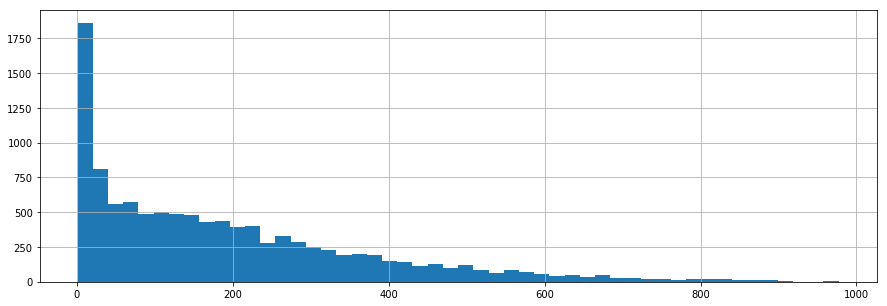

In [5]:
plt.figure(figsize=(15,5))
ts.hist(bins=50)


That is a bit hard to look at because of the range, so let's look at the log

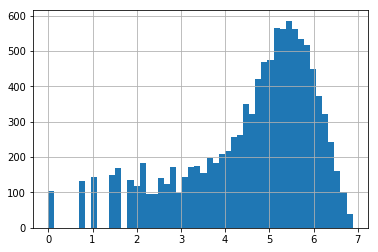

In [6]:
ts_log = np.log(ts)
ts_log.hist(bins=50)

I just want to point out that it is hard to use machine learning algorithms on bimodal data like this. We might want to bin it later in our machine-learning notebook.

# hypothesis 1: the information about registration vs casual will help us in our prediction
I'm going to also make data series of ts_casual and ts_registered that will analyze these populations separately. Together they sum to count.

In [7]:
ts_registered = data['registered']
ts_casual = data['casual']

Text(0,0.5,'count')

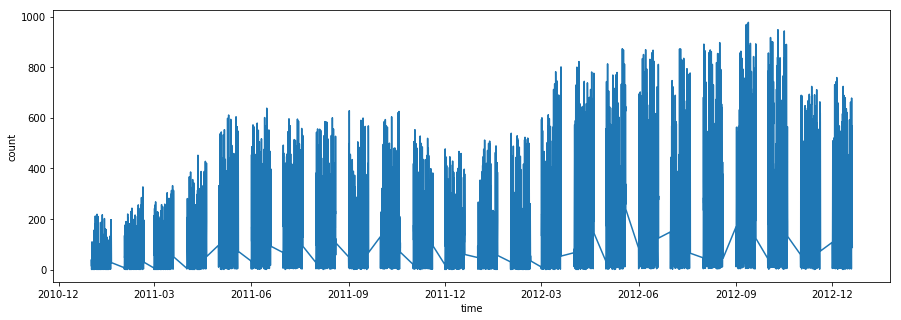

In [8]:
#let's take a look at the count data
plt.figure(figsize=(15,5))
plt.plot(ts)

plt.xlabel('time')
plt.ylabel('count')
#plt.savefig('timeseriesraw.png')

Text(0,0.5,'count')

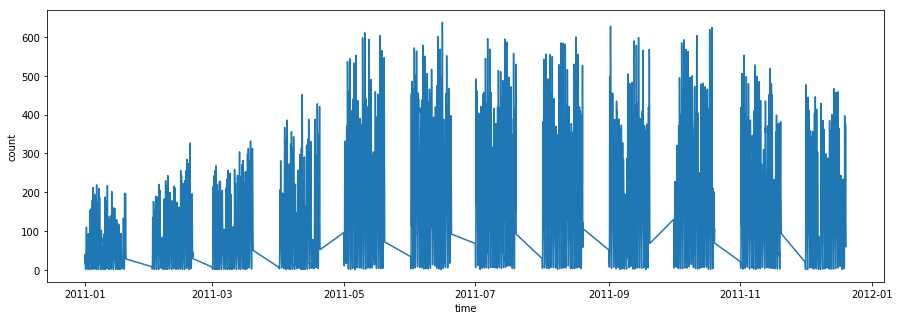

In [9]:
#zooming in on one year
plt.figure(figsize=(15,5))
plt.plot(ts['2011'])

plt.xlabel('time')
plt.ylabel('count')

Here we see a few things. First, there are only data for the beginning of each month, since kaggle used the end of the month for the test data. We can also see that we have several overlapping trends that we can deconvolve.

Text(0,0.5,'count')

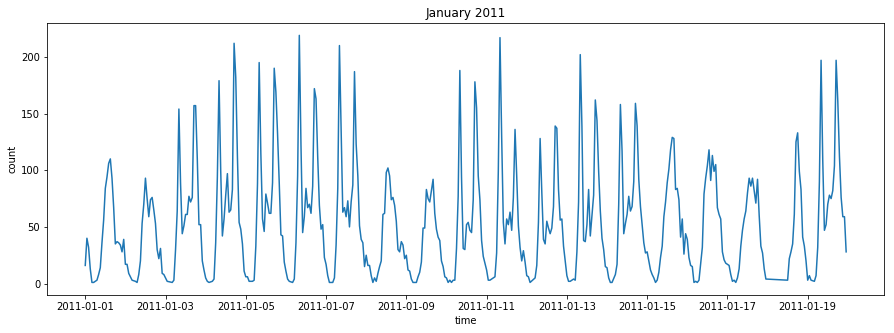

In [10]:
#let's take a look only January
plt.figure(figsize=(15,5))
plt.plot(ts['2011-01'])

plt.title('January 2011')
plt.xlabel('time')
plt.ylabel('count')

Just by eye we can kind of see that there is a different hourly behavior on 5 consecutive days, followed by 2 days with other behavior. Let's quantify this:

Text(0,0.5,'count')

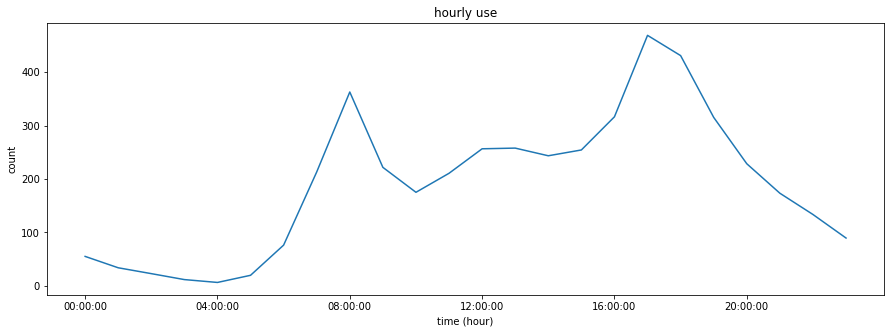

In [11]:
# Hourly use averaged over all days
by_time = ts.groupby(ts.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
plt.figure(figsize=(15,5))
by_time.plot(xticks=hourly_ticks);
plt.title('hourly use')
plt.xlabel('time (hour)')
plt.ylabel('count')

Text(0,0.5,'count')

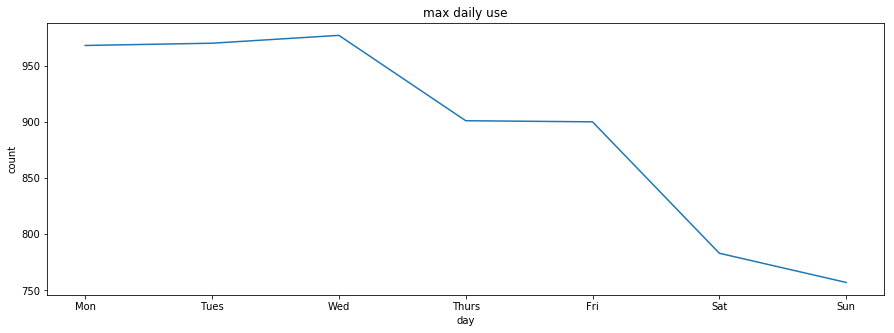

In [12]:
by_weekday = ts.groupby(ts.index.dayofweek).max()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(15,5))
by_weekday.plot(xticks = np.arange(7))
plt.title('max daily use')
plt.xlabel('day')
plt.ylabel('count')

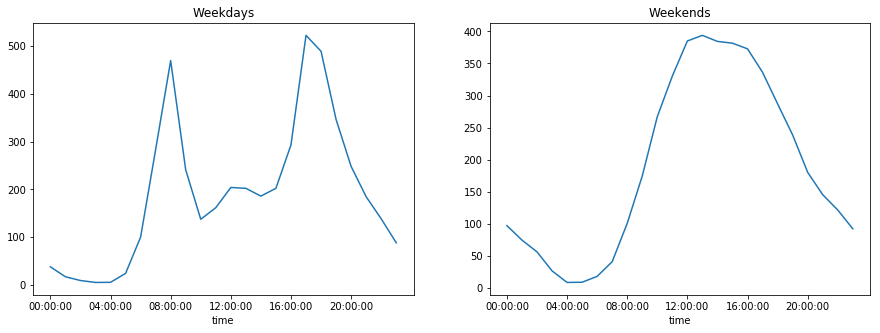

In [13]:
weekend = np.where(ts.index.weekday < 5, 'Weekday', 'Weekend')
by_time = ts.groupby([weekend, ts.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks)
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks)

So that is illuminating. 
next let's look at the overall trend an seasonality and see if we can find a way to decompose the series into its parts

We have here 3 levels of periodicity
 - seasonal
 - weekly
 - hourly
 
To consider the seasonality and overall trend, let's downsample to monthly averages. My thinking here is that we are seeing apparent commuter behavior, which might vary depending on if there's a holiday, and that there also are probably variations based on weather that will change from day to day, but the overall trends that the bikes are getting more popular with time and that there is still some seasonal variation in their use can be modeled using python. 

First, let's take a look if there's a difference between the casual and registered data...

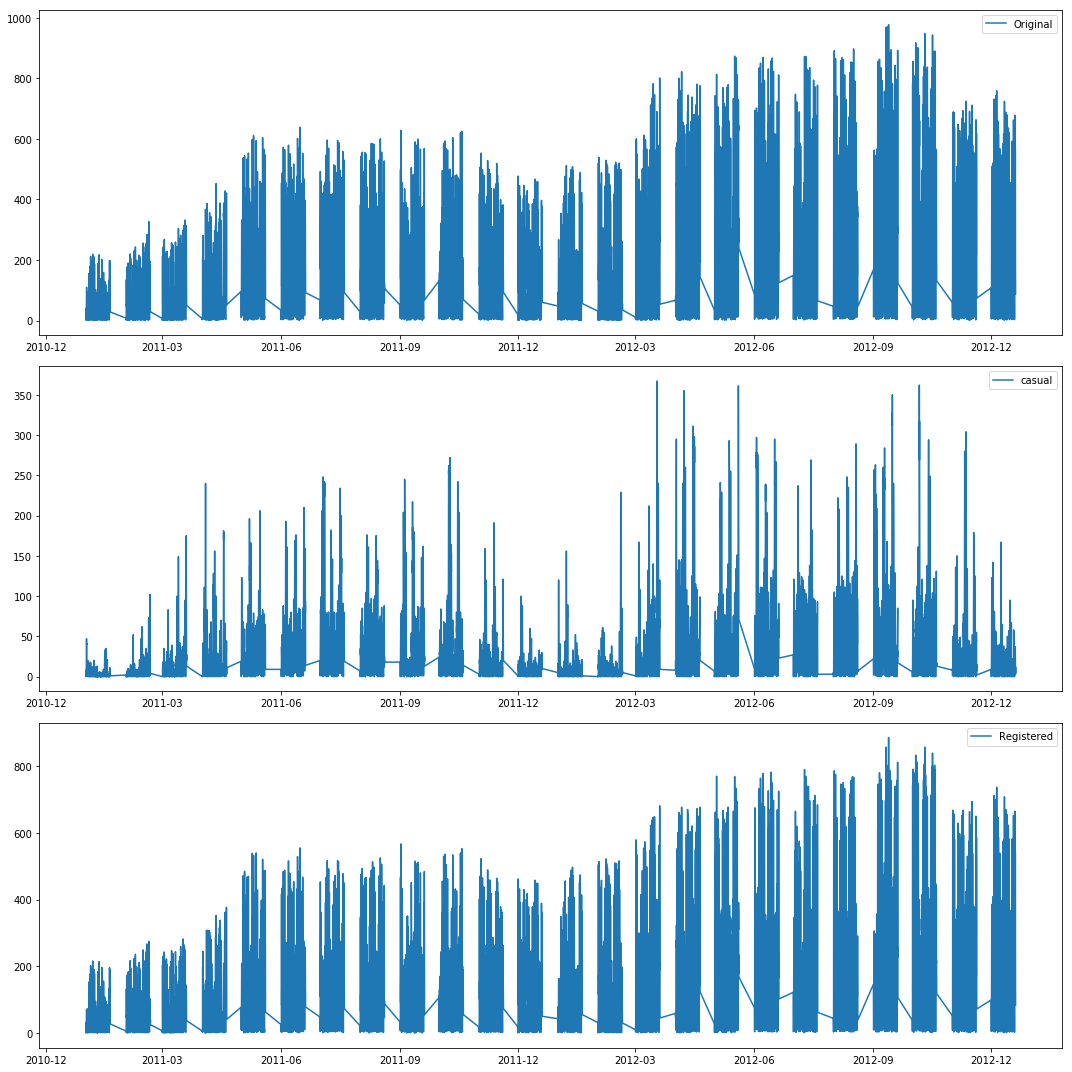

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(ts_casual, label='casual')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(ts_registered,label='Registered')
plt.legend(loc='best')
plt.tight_layout()


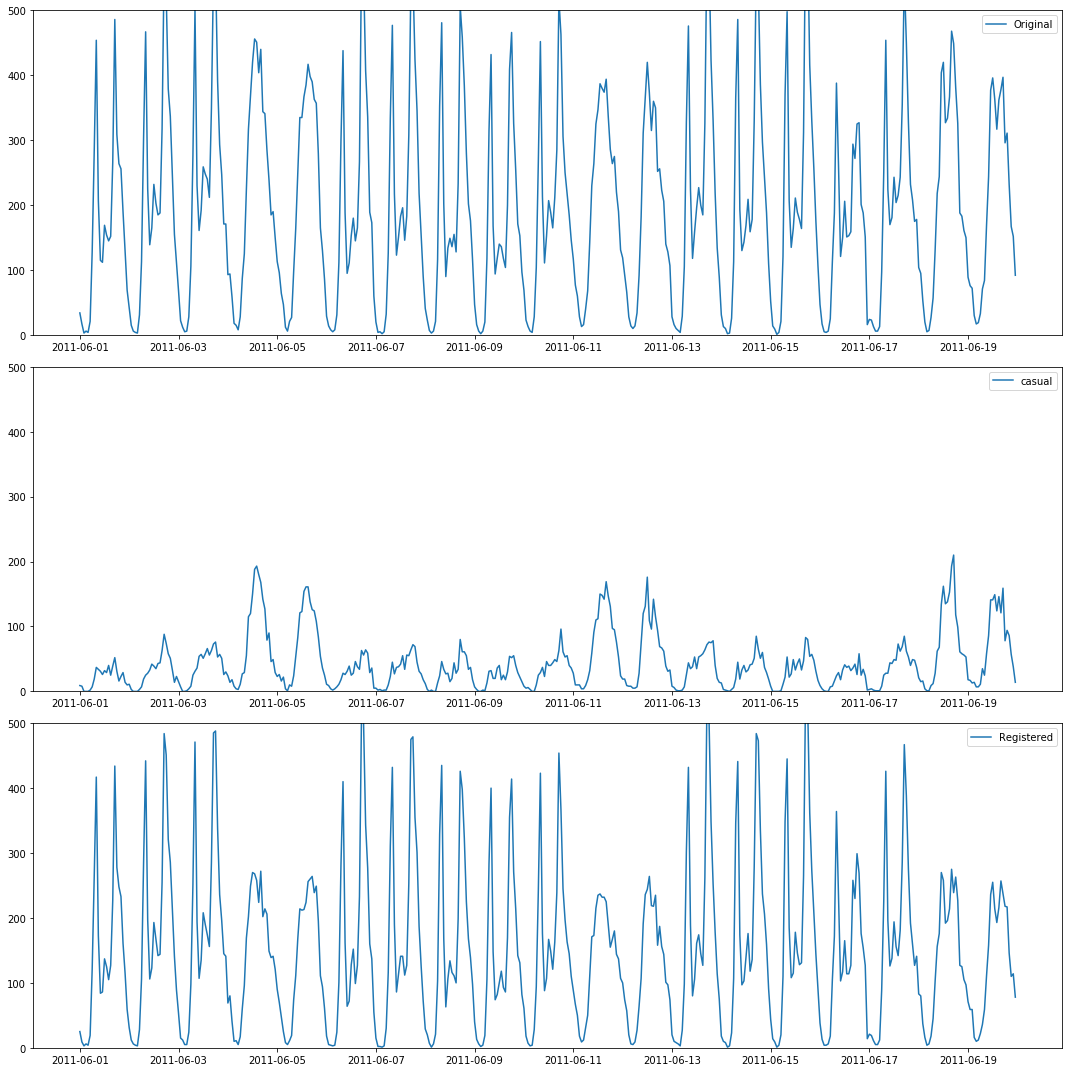

In [15]:
plt.figure(figsize=(15,15))

plt.subplot(311)
plt.ylim(0,500)
plt.plot(ts['2011-06'], label='Original')
plt.legend(loc='best')
plt.subplot(312)
plt.ylim(0,500)
plt.plot(ts_casual['2011-06'], label='casual')
plt.legend(loc='best')
plt.subplot(313)
plt.ylim(0,500)
plt.plot(ts_registered['2011-06'],label='Registered')
plt.legend(loc='best')
plt.tight_layout()

Here, i see that there are many fewer casual users overall, and there are quite a few random outliers in the casual data, and a much bigger seasonal trend in the casual riders than the registered ones. It also appears that neither the casual nor the registered users are really riding at night, but let's take a 
closer look at the hourly and daily patterns here:

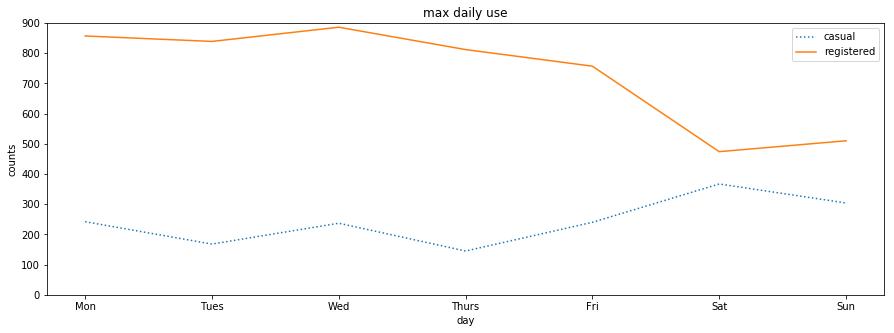

In [16]:
by_weekday_cas = ts_casual.groupby(ts_casual.index.dayofweek).max()
by_weekday_cas.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(15,5))
plt.ylim(0,900)
by_weekday_cas.plot(xticks = np.arange(7),style = ':')
plt.title('max daily use')
plt.xlabel('day')
plt.ylabel('counts')
by_weekday_reg = ts_registered.groupby(ts_registered.index.dayofweek).max()
by_weekday_reg.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday_reg.plot(xticks = np.arange(7))
plt.legend(loc='best')


The registered users seem to have a pretty consistent trend that is the basis for the maximum use, so I'm going to take the maximum monthly use for those guys. The casual users have wild outliers in the monthly maxima, so I'm going to use the mean.

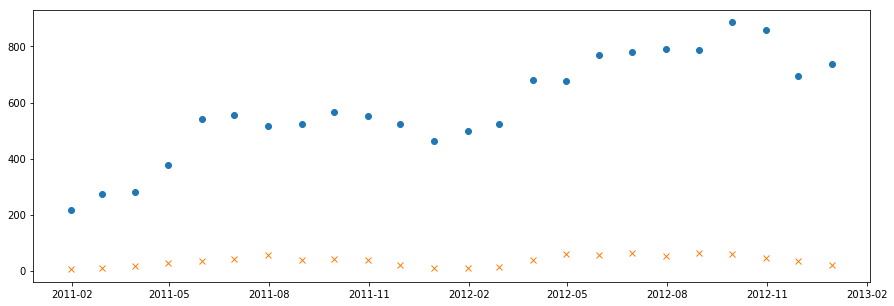

In [54]:
# now averaging over the whole month and plotting the whole range
plt.figure(figsize=(15,5))
monthly_reg = ts_registered.resample('M').max()
monthly_cas = ts_casual.resample('M').mean()
#monthly.head()
plt.plot(monthly_reg, 'o')
plt.plot(monthly_cas,'x')

We see here a monotonically increasing trend and seasonal variability. But how to quantify it? If we only need to estimate the average or maximum monthly use, then this will be enough to predict that and this is a simple approach because of python's handling of decomposing time series by trend and seasonality.

To quantify the statistics of these trends, let's look at the rolling mean and standard deviation and perform the Dickey-Fuller test, which is somewhat overkill in this case, but could be useful in other cases.


In [55]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=2,center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=2,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

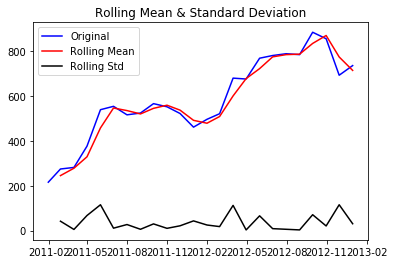

Results of Dickey-Fuller Test:
Test Statistic                 -1.980573
p-value                         0.295156
#Lags Used                      0.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


In [56]:
test_stationarity(monthly_reg)

In this case, the variation in standard deviation is relatively small, but the mean is varying with time and this is not a stationary series. Also, the test statistic is much higher than the critical values (comparing the signed values and not the absolute values).

# Decomposing trend and seasonality

python has a great tool for decomposing the trend and seasonality of a data set. Let's use it to decompose our data.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2011-01-31 to 2012-12-31
Freq: M
Data columns (total 4 columns):
data        24 non-null int64
trend       12 non-null float64
seasonal    24 non-null float64
residual    12 non-null float64
dtypes: float64(3), int64(1)
memory usage: 960.0 bytes
None


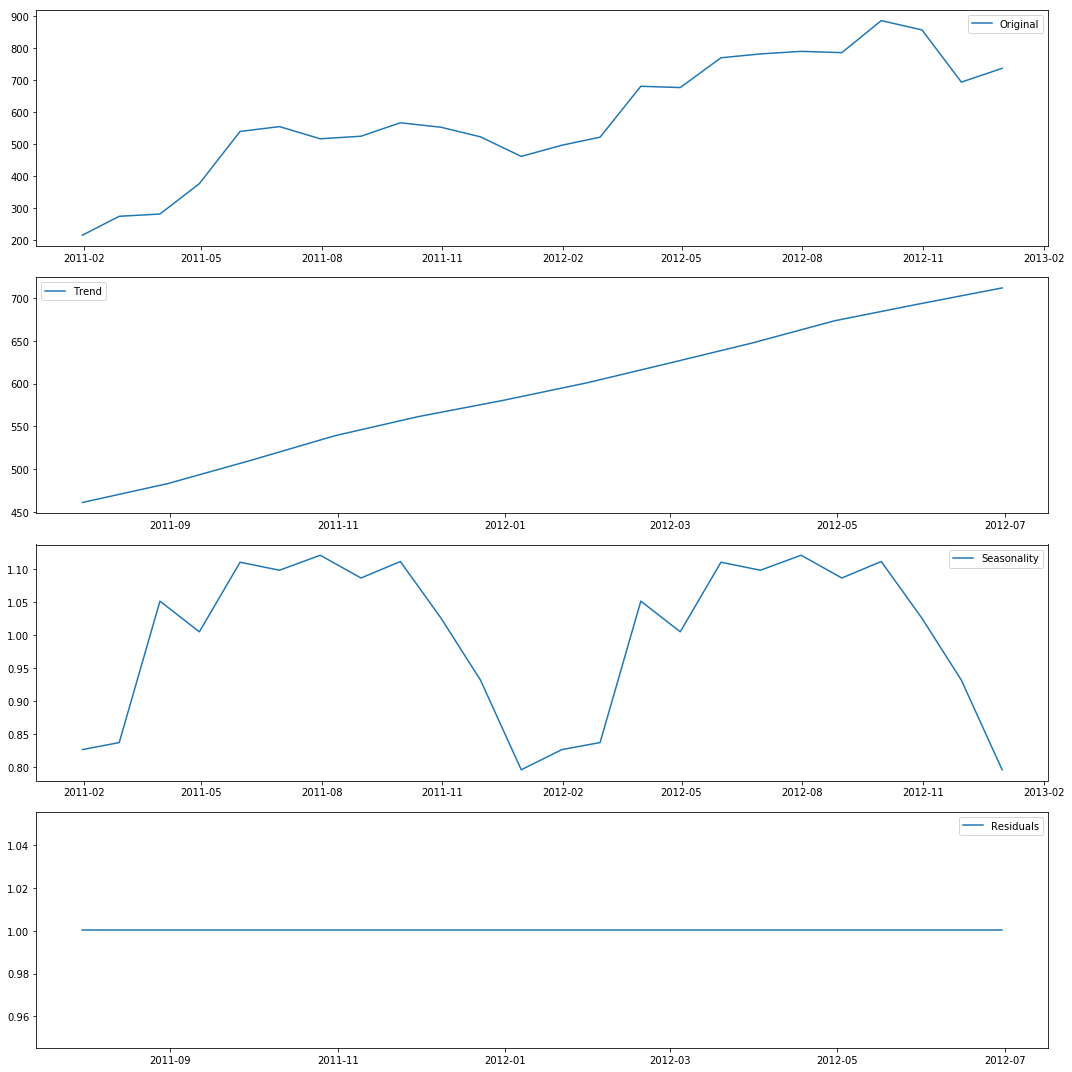

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_reg,model = 'm')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(monthly_reg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_decomposed = pd.DataFrame()
ts_decomposed['data'] = monthly_reg
ts_decomposed['trend'] = trend
ts_decomposed['seasonal'] = seasonal
ts_decomposed['residual'] = residual
print(ts_decomposed.info())

We have to extrapolate the trend and residuals to represent all the data. To do that, I'll fit the trend to a line and input the whole range to that fit.

In [58]:
t2 = ts_decomposed.dropna()
x = mdates.date2num(t2.index)
z = np.polyfit(x,y=t2['trend'],deg=1) #fit a 1 degree polynomial to the trend time
p = np.poly1d(z)

            data       trend  seasonal  residual
datetime                                        
2011-01-31   216  328.223217  0.826547       NaN
2011-02-28   275  349.266894  0.837134       NaN
2011-03-31   282  372.565251  1.051359       NaN
2011-04-30   377  395.112048  1.004895       NaN
2011-05-31   540  418.410405  1.110307       NaN


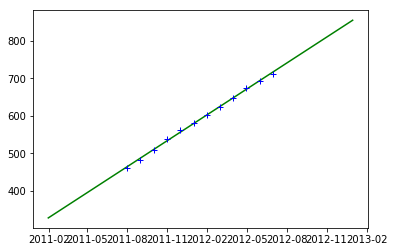

In [59]:
xx = mdates.date2num(ts_decomposed.index)
dd = mdates.num2date(xx)

plt.plot(dd, p(xx), '-g')
plt.plot(x, t2['trend'], '+', color='b', label='blub')
ts_decomposed['trend'] = p(xx)
print(ts_decomposed.head())


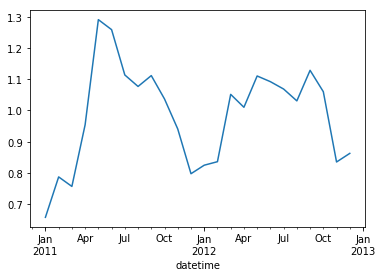

In [60]:
intermed = ts_decomposed['data'] / ts_decomposed['trend']
intermed.plot()

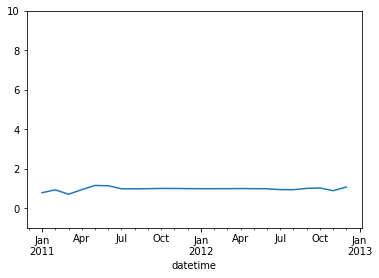

In [61]:
plt.ylim([-1,10])
ts_decomposed['residual'] = ts_decomposed['data'] / ts_decomposed['trend'] / ts_decomposed['seasonal']
ts_decomposed['residual'].plot()

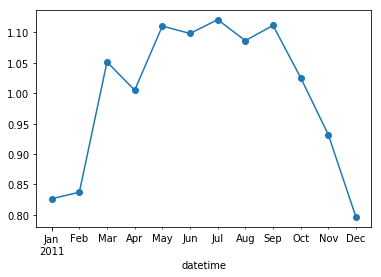

In [62]:
# looking at the monthly index
s_2011=seasonal['2011']
s_2011.plot(marker ='o')


Now I'm just going to interpolate between the points and fill the missing points with the max for January 2011 and reindex to match ts_registered. 

We are going to divide by this approximation of the seasonality. 

In [63]:
seasonal = seasonal.resample('1H')
s_interpolated = seasonal.interpolate(method='linear')
print(s_interpolated.head())
seasonal_ts = s_interpolated.reindex(ts_registered.index)
# after reindexing I have to back fill the NAs. The easiest thing to do is just give all January 2011 the same value.
seasonal_ts = seasonal_ts.fillna(method='bfill',limit=4000)
seasonal_ts.head()

datetime
2011-01-31 00:00:00    0.826547
2011-01-31 01:00:00    0.826563
2011-01-31 02:00:00    0.826579
2011-01-31 03:00:00    0.826595
2011-01-31 04:00:00    0.826610
Freq: H, Name: registered, dtype: float64


datetime
2011-01-01 00:00:00    0.826925
2011-01-01 01:00:00    0.826925
2011-01-01 02:00:00    0.826925
2011-01-01 03:00:00    0.826925
2011-01-01 04:00:00    0.826925
Name: registered, dtype: float64

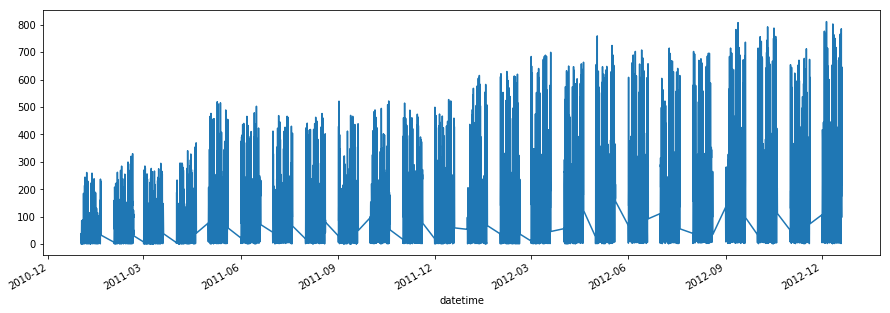

In [64]:
plt.figure(figsize=(15,5))

unseasonal_reg = ts_registered/seasonal_ts
unseasonal_reg.plot()

Now to reindex and scale the original data using the p(x) fit to the trendline from above

In [65]:
ts_reg_reindexed = ts_decomposed.reindex(ts_registered.index)
#print(ts_reg_reindexed.info())
x_reindexed = mdates.date2num(ts_reg_reindexed.index)
trend_new = p(x_reindexed)
ts_reg_reindexed['trend'] = trend_new
ts_reg_reindexed['data'] = ts_registered
ts_reg_reindexed['seasonal'] = seasonal_ts
print(ts_reg_reindexed.head())


                     data       trend  seasonal  residual
datetime                                                 
2011-01-01 00:00:00    13  305.676420  0.826925       NaN
2011-01-01 01:00:00    32  305.707735  0.826925       NaN
2011-01-01 02:00:00    27  305.739050  0.826925       NaN
2011-01-01 03:00:00    10  305.770365  0.826925       NaN
2011-01-01 04:00:00     1  305.801680  0.826925       NaN


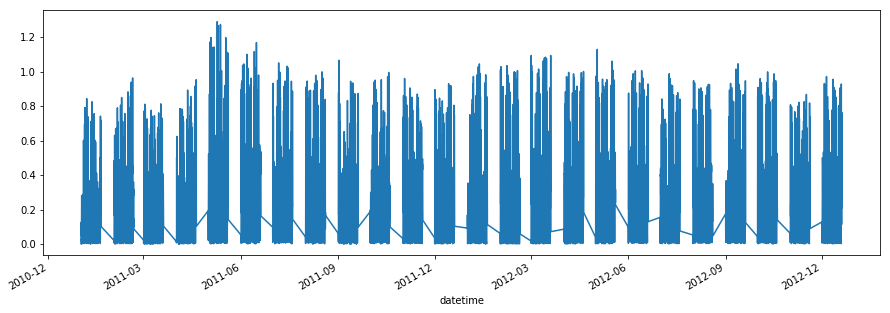

In [66]:
ts_reg_stationary = ts_reg_reindexed['data']/ts_reg_reindexed['trend']/ts_reg_reindexed['seasonal']
ts_reg_reindexed['residual'] = ts_reg_stationary
plt.figure(figsize=(15,5))
ts_reg_stationary.plot()

# we can use this deconvolved data to check out the daily and hourly behavior

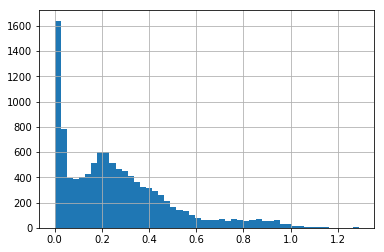

In [67]:
ts_reg_stationary.hist(bins=50)

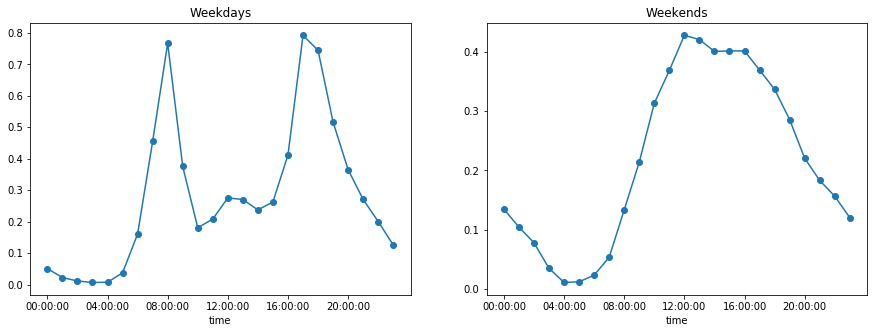

In [68]:
weekend = np.where(ts_reg_stationary.index.weekday < 5, 'Weekday', 'Weekend')
by_time = ts_reg_stationary.groupby([weekend, ts_reg_stationary.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks,marker='o')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks,marker='o')

In [69]:
by_time.head()

Weekday  00:00:00    0.051152
         01:00:00    0.022648
         02:00:00    0.011697
         03:00:00    0.007051
         04:00:00    0.007618
dtype: float64

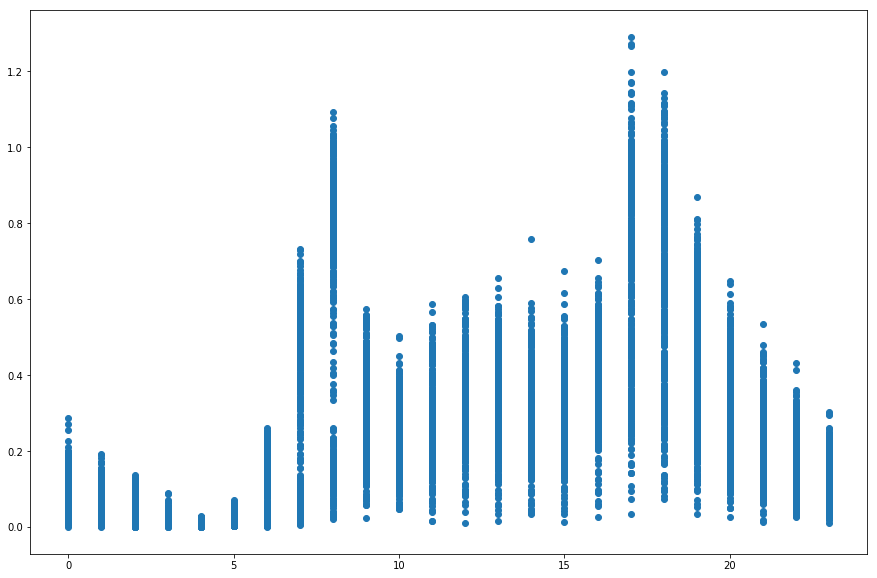

In [70]:
x=pd.DataFrame()
x['hours']=ts_reg_stationary.index.hour
x['Dates']=ts_reg_stationary.index
x['data']=ts_reg_stationary.data
x['dayofweek']=ts_reg_stationary.index.weekday
y_weekday=x[x['dayofweek'] < 5].pivot(index='Dates', columns='hours', values='data')
plt.figure(figsize=(15,10))
#y_weekday.boxplot()
plt.scatter(x['hours'],x['data'])

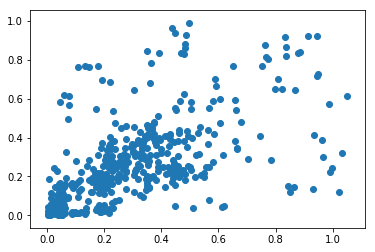

In [71]:
plt.scatter(ts_reg_stationary['2011-07'],ts_reg_stationary['2012-07'])

this is about all we can do here since there is a lot of variation between individual days. I'll export this stationary data and we can do some additional analysis.

In [72]:
ts_reg_reindexed.to_csv('registered_stationary.csv')

Now let's do it all again for casual

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2011-01-31 to 2012-12-31
Freq: M
Data columns (total 4 columns):
data        24 non-null float64
trend       12 non-null float64
seasonal    24 non-null float64
residual    12 non-null float64
dtypes: float64(4)
memory usage: 960.0 bytes
None


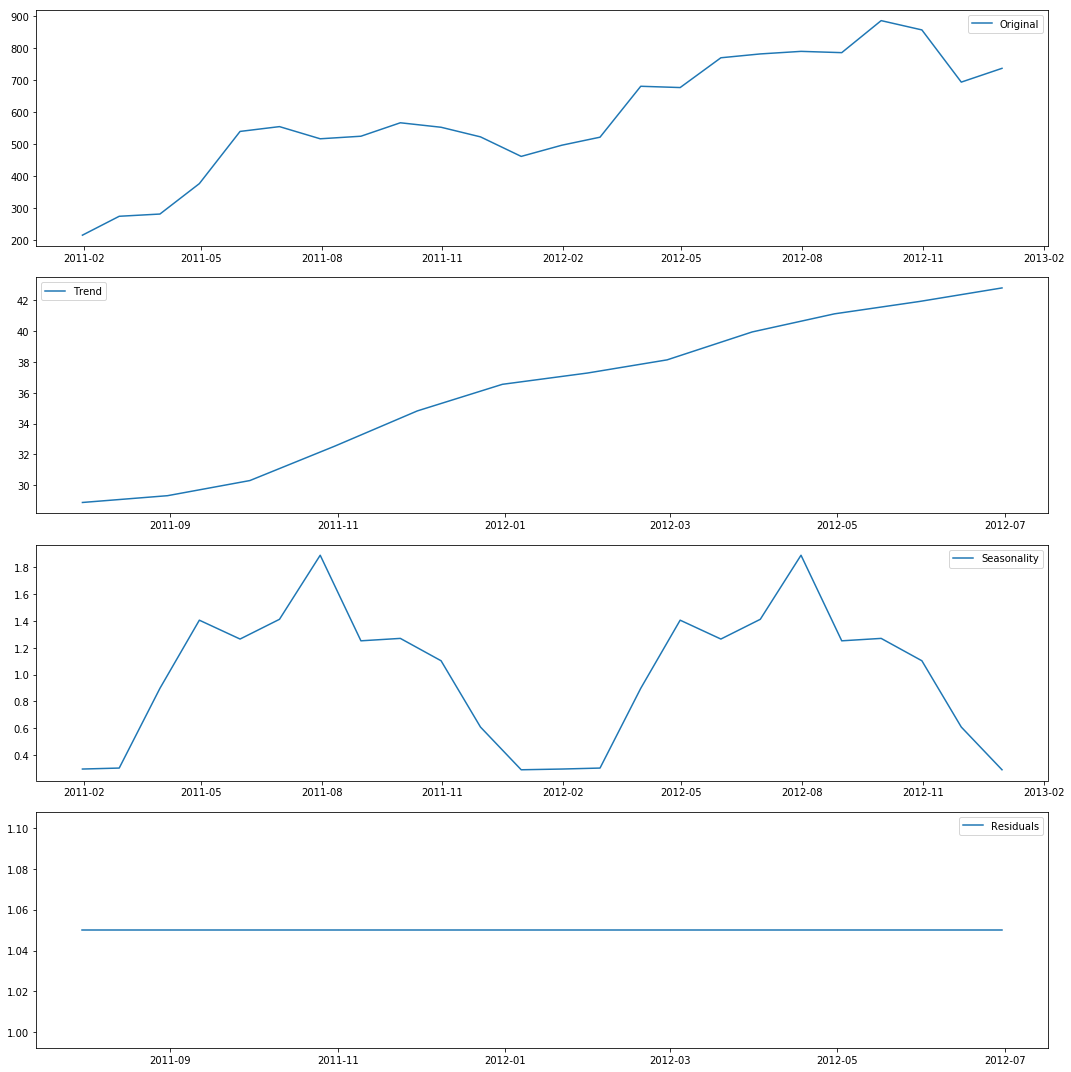

In [73]:
decomposition = seasonal_decompose(monthly_cas,model = 'm')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(monthly_reg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_decomposed = pd.DataFrame()
ts_decomposed['data'] = monthly_cas
ts_decomposed['trend'] = trend
ts_decomposed['seasonal'] = seasonal
ts_decomposed['residual'] = residual
print(ts_decomposed.info())

In [74]:
t2 = ts_decomposed.dropna()
x = mdates.date2num(t2.index)
z = np.polyfit(x,y=t2['trend'],deg=1) #fit a 1 degree polynomial to the trend time
p = np.poly1d(z)

                 data      trend  seasonal  residual
datetime                                            
2011-01-31   4.658933  20.476198  0.295668       NaN
2011-02-28   8.466368  21.733150  0.302962       NaN
2011-03-31  17.735426  23.124775  0.898128       NaN
2011-04-30  26.876923  24.471509  1.406602       NaN
2011-05-31  34.791667  25.863134  1.265800       NaN


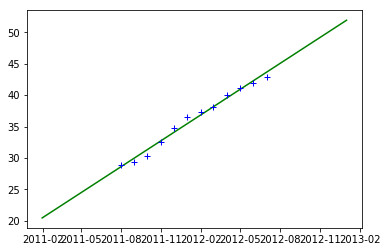

In [75]:
xx = mdates.date2num(ts_decomposed.index)
dd = mdates.num2date(xx)

plt.plot(dd, p(xx), '-g')
plt.plot(x, t2['trend'], '+', color='b', label='blub')
ts_decomposed['trend'] = p(xx)
print(ts_decomposed.head())

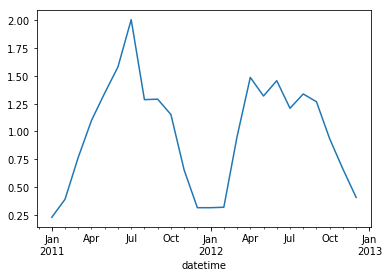

In [76]:
intermed = ts_decomposed['data'] / ts_decomposed['trend']
intermed.plot()

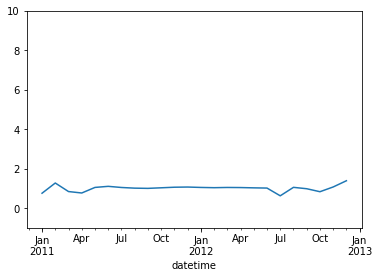

In [77]:
plt.ylim([-1,10])
ts_decomposed['residual'] = ts_decomposed['data'] / ts_decomposed['trend'] / ts_decomposed['seasonal']
ts_decomposed['residual'].plot()

In [78]:
seasonal = seasonal.resample('1H')
s_interpolated = seasonal.interpolate(method='linear')
print(s_interpolated.head())
seasonal_ts = s_interpolated.reindex(ts_casual.index)
# after reindexing I have to back fill the NAs. The easiest thing to do is just give all January 2011 the same value.
seasonal_ts = seasonal_ts.fillna(method='bfill',limit=4000)
seasonal_ts.head()

datetime
2011-01-31 00:00:00    0.295668
2011-01-31 01:00:00    0.295679
2011-01-31 02:00:00    0.295689
2011-01-31 03:00:00    0.295700
2011-01-31 04:00:00    0.295711
Freq: H, Name: casual, dtype: float64


datetime
2011-01-01 00:00:00    0.295928
2011-01-01 01:00:00    0.295928
2011-01-01 02:00:00    0.295928
2011-01-01 03:00:00    0.295928
2011-01-01 04:00:00    0.295928
Name: casual, dtype: float64

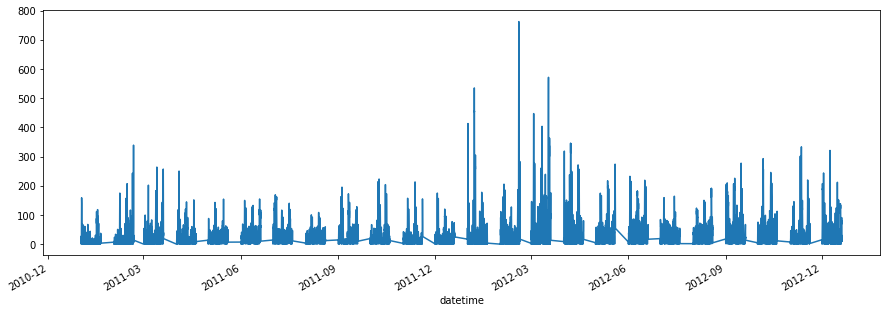

In [79]:
plt.figure(figsize=(15,5))

unseasonal_cas = ts_casual/seasonal_ts
unseasonal_cas.plot()

In [80]:
ts_cas_reindexed = ts_decomposed.reindex(ts_casual.index)
#print(ts_reg_reindexed.info())
x_reindexed = mdates.date2num(ts_cas_reindexed.index)
trend_new = p(x_reindexed)
ts_cas_reindexed['trend'] = trend_new
ts_cas_reindexed['data'] = ts_casual
ts_cas_reindexed['seasonal'] = seasonal_ts
print(ts_cas_reindexed.head())


                     data      trend  seasonal  residual
datetime                                                
2011-01-01 00:00:00     3  19.129464  0.295928       NaN
2011-01-01 01:00:00     8  19.131334  0.295928       NaN
2011-01-01 02:00:00     5  19.133205  0.295928       NaN
2011-01-01 03:00:00     3  19.135075  0.295928       NaN
2011-01-01 04:00:00     0  19.136946  0.295928       NaN


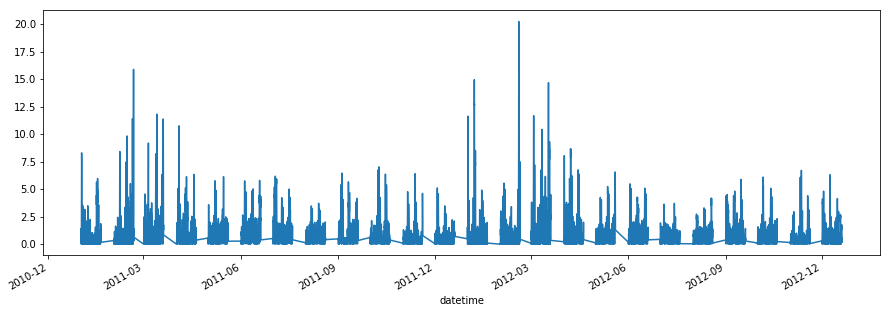

In [81]:
ts_cas_stationary = ts_cas_reindexed['data']/ts_cas_reindexed['trend']/ts_cas_reindexed['seasonal']
ts_cas_reindexed['residual'] = ts_cas_stationary
plt.figure(figsize=(15,5))
ts_cas_stationary.plot()

In [82]:
ts_cas_reindexed.to_csv('casual_stationary.csv')